**Baseline model:**
As we are dealing with a balanced binary classification, a dummy classifier will give an accuracy of 0.5

**Model Evaluation:**
As we are dealing with balanced binary classification problem, we can choose accuracy as evaluation method
- Accuracy
- Feature Importance Evaluation
- Ablation Analysis/Model Sensitivity/Occam's Razor 

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

X_all = pd.read_csv("D:\Python\data\Simpsons\X_all.csv", index_col=0)
y_all = pd.read_csv("D:\Python\data\Simpsons\y_all.csv", index_col=0)

In [2]:
related_cols=['number_in_season', 'number_in_series', 'original_air_year','season', 'us_viewers_in_millions','views']
X_all[['number_in_series', 'original_air_year','season']].corr()

# X_all = X_all.drop('season',1)
# X_all = X_all.drop('number_in_series',1)
# X_all = X_all.drop(['number_in_series', 'season'],1)
# including both 'season', 'original_air_year' and 'number_in_series' actually boosted model performance in general even they are highly correlated

,number_in_series,original_air_year,season
number_in_series,1.000000,0.999141,0.999073
original_air_year,0.999141,1.000000,0.998030
season,0.999073,0.998030,1.000000


In [3]:
# Imputation metodhs:
X_all_mean_imputed = X_all.fillna(X_all.mean())
X_all_median_imputed = X_all.fillna(X_all.median())
X_all_zero_imputed = X_all.fillna(0)

In [4]:
# Feature Selection based on number of lines character have spoken across all seasons (top 20 characters)

top_columns = ['episode_id','number_in_season', 'number_in_series', 'season',
               'original_air_year', 'us_viewers_in_millions', 'views',
               'Homer Simpson', 'Marge Simpson', 'Bart Simpson', 'Lisa Simpson',
               'C. Montgomery Burns', 'Moe Szyslak', 'Seymour Skinner', 'Ned Flanders',
               'Grampa Simpson', 'Milhouse Van Houten', 'Chief Wiggum',
               'Krusty the Clown', 'Nelson Muntz', 'Lenny Leonard',
               'Apu Nahasapeemapetilon', 'Waylon Smithers', 'Kent Brockman',
               'Carl Carlson', 'Edna Krabappel-Flanders', 'Dr. Julius Hibbert']

# 1. Logistic Regression (accuracy: 0.83 - 0.865)

In [5]:
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score
from sklearn.model_selection import cross_validate, KFold

In [6]:
def performacne_plots(tresholds_p_r, tresholds_roc, precision, recall, fp, tp, auc_score):
    close_default = np.argmin(np.abs(tresholds_p_r-0.5))
    close_zero = np.argmin(np.abs(tresholds_roc))

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,4))

    ax1.plot(precision, recall, label='Precision Recall Curve')
    ax1.plot(precision[close_default], recall[close_default], 'o', fillstyle='none', c='r', markersize=10, mew=2, label=' treshold 0.5')
    ax1.set_title('RF performance')
    ax1.set_xlabel('Precision')
    ax1.set_ylabel('Recall')
    ax1.legend(loc='best')

    ax2.plot(fp, tp, label='ROC curve')
    ax2.plot(fp[close_zero], tp[close_zero], 'o', fillstyle='none', c='r', markersize=10, mew=2, label='treshold 0')   
    ax2.set_title(f'ROC performance: AUC score {auc_score}') 
    ax2.set_xlabel('False Positive Rate')
    ax2.set_ylabel('True Positive Rate')
    ax2.legend(loc='best')

    return fig

def classifier_assessment(X, y, clf, show_graph=True):
    """
    args:   X dataset of features
            y target set of values for classification

    returns:
            - the mean of the Logistic Regression Classifier prediction scores taken from
            a 5 fold cross validation on the dataset
    """
    kfold = KFold(n_splits=5)
    cross_val = cross_validate(clf, X, y, cv=kfold, return_estimator=True)
    mean_score = cross_val['test_score'].mean()

    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
    clf.fit(X_train, y_train)

    proba_ = clf.predict_proba(X_test)[:, 1]
    precision, recall, tresholds_p_r =precision_recall_curve(y_test, proba_)
    fp, tp, tresholds_roc = roc_curve(y_test, proba_)

    auc_score = np.round(roc_auc_score(y_test, proba_), 4)

    # plot graph automatically'
    if show_graph:
        performacne_plots(tresholds_p_r, tresholds_roc, precision, recall, fp, tp, auc_score)

    return mean_score, clf


0.845

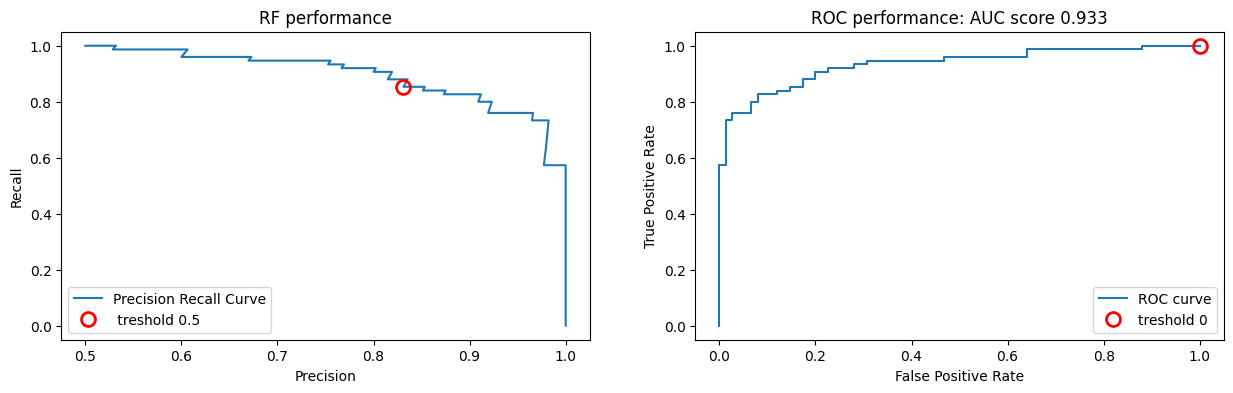

In [7]:
np.random.seed(0)

import warnings
warnings.filterwarnings('ignore')

clf_log = LogisticRegression(random_state=0)
mean_score, clf_log = classifier_assessment(X_all_mean_imputed, y_all, clf_log)
mean_score

0.8649999999999999

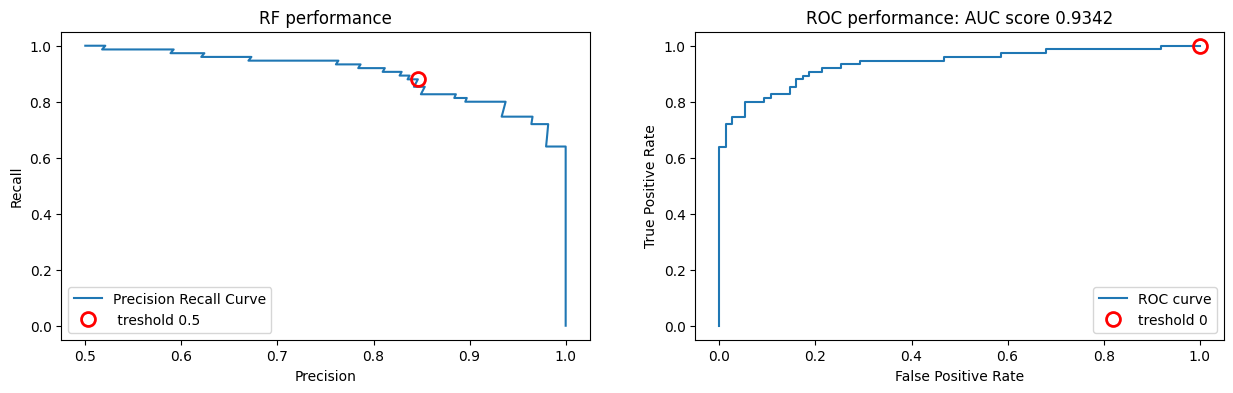

In [8]:
clf_log_top_mean = LogisticRegression(random_state=0)
mean_score, clf_log_top_mean = classifier_assessment(X_all[top_columns].fillna(X_all[top_columns].mean()), y_all, clf_log_top_mean)
mean_score

0.8316666666666667

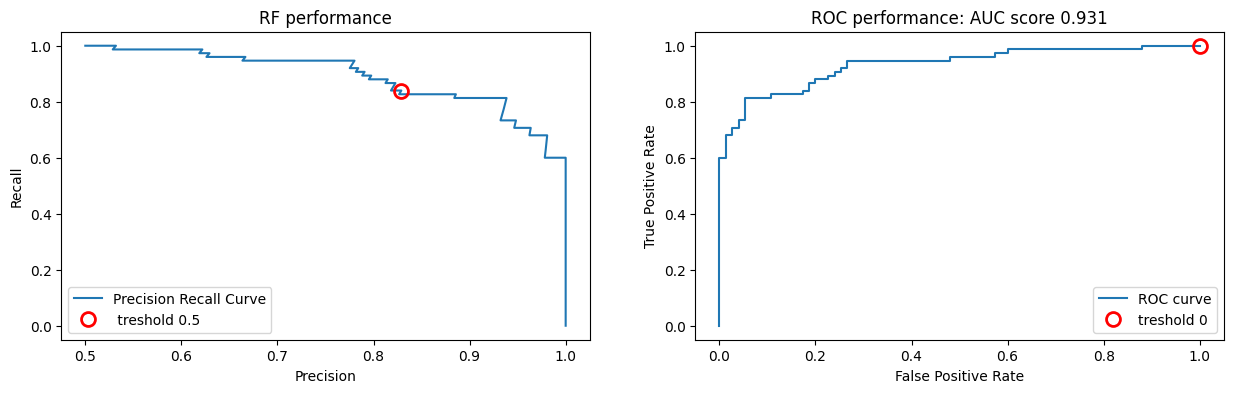

In [9]:
# when impute with 0, mean accuracy and ROC score are not as good
clf_log2 = LogisticRegression(random_state=0)
mean_score, clf_log2 = classifier_assessment(X_all_zero_imputed, y_all, clf_log2)
mean_score

0.8466666666666667

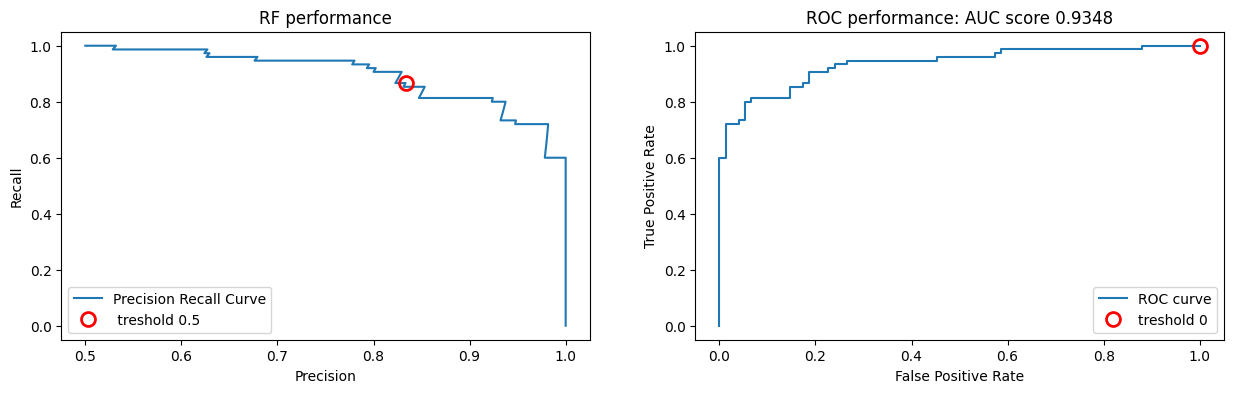

In [10]:
clf_log_top_zero = LogisticRegression(random_state=0)
mean_score, clf_log_top_zero = classifier_assessment(X_all[top_columns].fillna(0), y_all, clf_log_top_zero)
mean_score

0.8566666666666667

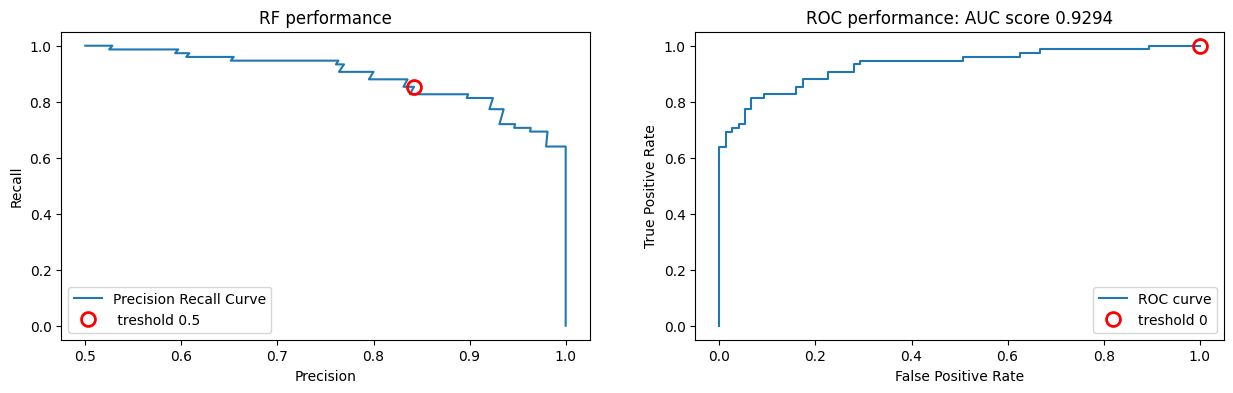

In [11]:
# when impute with median the mean accuracy is higher, but ROC score is not as good
clf_log3 = LogisticRegression(random_state=0)
mean_score, clf_log3 = classifier_assessment(X_all_median_imputed, y_all, clf_log3)
mean_score

0.8566666666666667

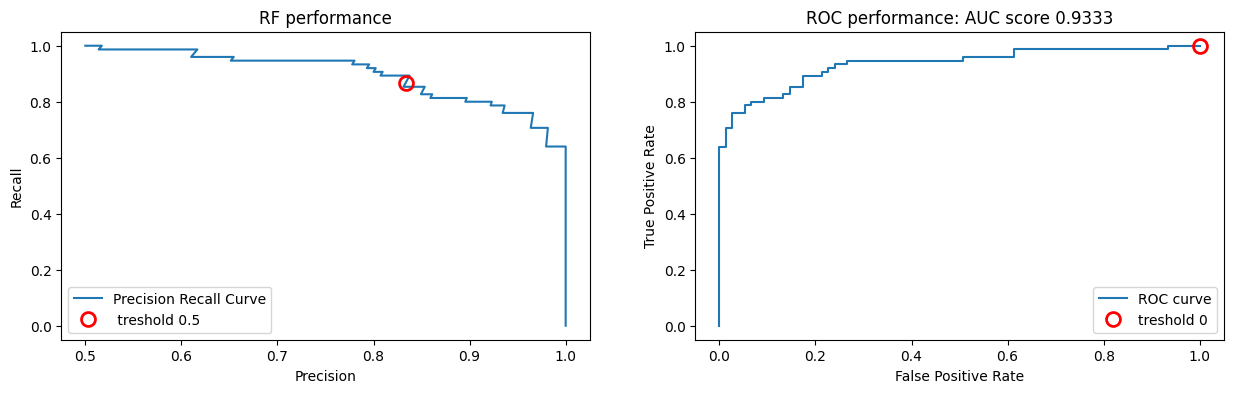

In [12]:
clf_log_top_median = LogisticRegression(random_state=0)
mean_score, clf_log_top_median = classifier_assessment(X_all[top_columns].fillna(X_all[top_columns].median()), y_all, clf_log_top_median)
mean_score

In [13]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

In [14]:
pipe = Pipeline([('classifier', LogisticRegression(random_state=1))])
param_grid = [{ 'classifier': [LogisticRegression(random_state=1)],
               'classifier__penalty': ['l1', 'l2'],
               'classifier__C': np.logspace(-4,4,20),
               'classifier__solver': ['liblinear']}]

clf_cv = GridSearchCV(pipe, param_grid=param_grid, cv=5, verbose=True, n_jobs=-1)

X_train, X_test, y_train, y_test = train_test_split(X_all_median_imputed, y_all['popularity_class'].ravel(), random_state=1)
clf_cv.fit(X_train, y_train)
clf_cv.best_params_

Fitting 5 folds for each of 40 candidates, totalling 200 fits


{'classifier': LogisticRegression(C=0.00026366508987303583, random_state=1, solver='liblinear'),
 'classifier__C': 0.00026366508987303583,
 'classifier__penalty': 'l2',
 'classifier__solver': 'liblinear'}

In [15]:
clf_top_cv = GridSearchCV(pipe, param_grid=param_grid, cv=5, verbose=True, n_jobs=-1)

X_train_top, X_test_top, y_train_top, y_test_top = train_test_split(X_all[top_columns].fillna(X_all[top_columns].mean()),
                                                                    y_all['popularity_class'].ravel(),
                                                                    random_state=1)
clf_top_cv.fit(X_train_top, y_train_top)
clf_top_cv.best_params_

Fitting 5 folds for each of 40 candidates, totalling 200 fits


{'classifier': LogisticRegression(C=0.00026366508987303583, random_state=1, solver='liblinear'),
 'classifier__C': 0.00026366508987303583,
 'classifier__penalty': 'l2',
 'classifier__solver': 'liblinear'}

0.8633333333333333

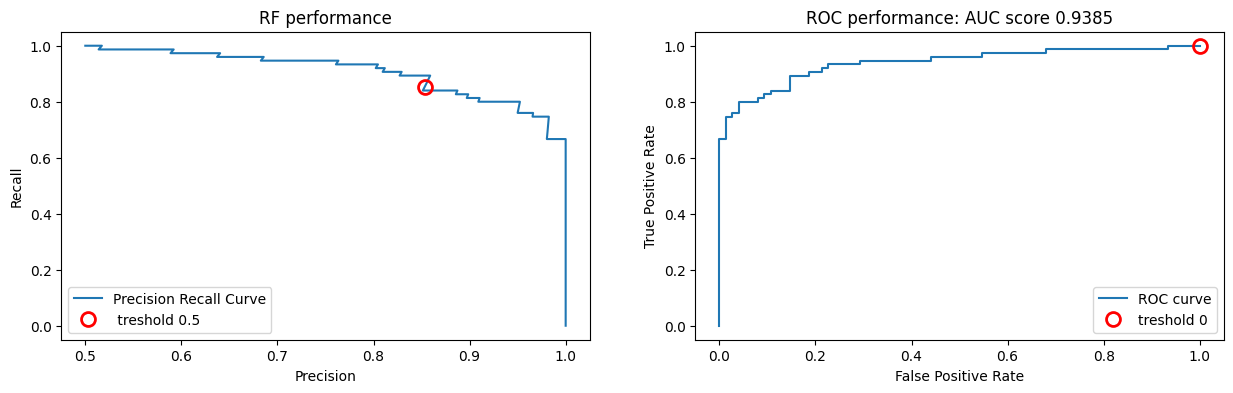

In [16]:
clf_log_best = LogisticRegression(C=clf_cv.best_params_['classifier__C'],
                                  solver=clf_cv.best_params_['classifier__solver'],
                                  random_state=1)

mean_score, clf_log_best = classifier_assessment(X_all_median_imputed, y_all, clf_log_best)
mean_score

0.8633333333333333

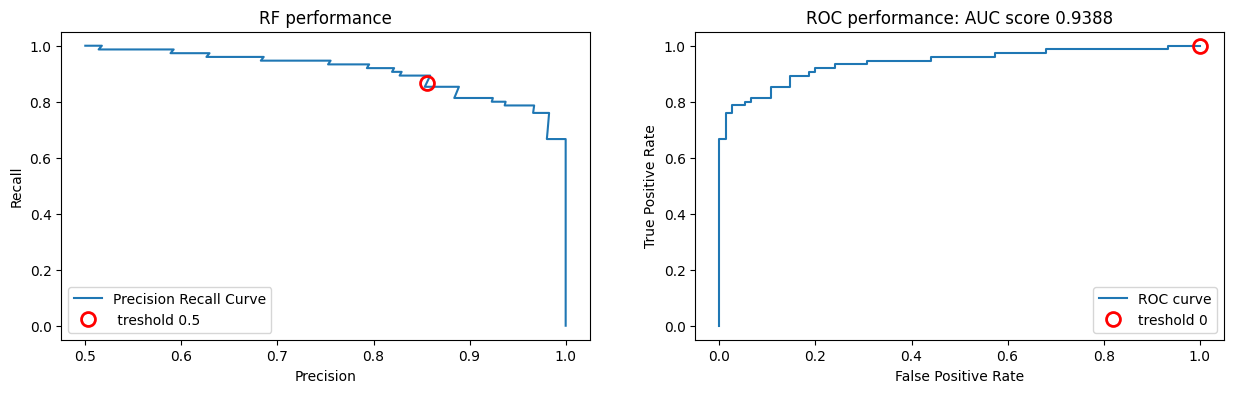

In [17]:
clf_log_best_top = LogisticRegression(C=clf_top_cv.best_params_['classifier__C'],
                                      solver=clf_top_cv.best_params_['classifier__solver'],
                                      random_state=1)
mean_score, clf_log_best_top = classifier_assessment(X_all[top_columns].fillna(X_all[top_columns].mean()), y_all, clf_log_best_top)
mean_score

## Feature analysis

In [18]:
def feat_importance_eval(clf, columns=X_all.columns):
    try:
        importances = clf.feature_importances_
    except:
        importances = clf.coef_[0]
        
    importance_dict = {}
    for importance, name in zip(importances, columns):
        if importance!=0:
            importance_dict[name]=importance
            
    importance_dict = sorted(importance_dict.items(), key=lambda x: -x[-1])[:10]
    return importance_dict

def plot_feature_importance(importance_dict):
    plt.figure(figsize=(15,6))
    x_label = [x[0] for x in importance_dict]
    x_coords = list(range(len(importance_dict)))
    plt.bar(x=x_coords, 
            width=0.5,
            height=[x[-1] for x in importance_dict],
            tick_label=x_label)

    plt.gca().set_xticklabels(rotation=45, labels=x_label)

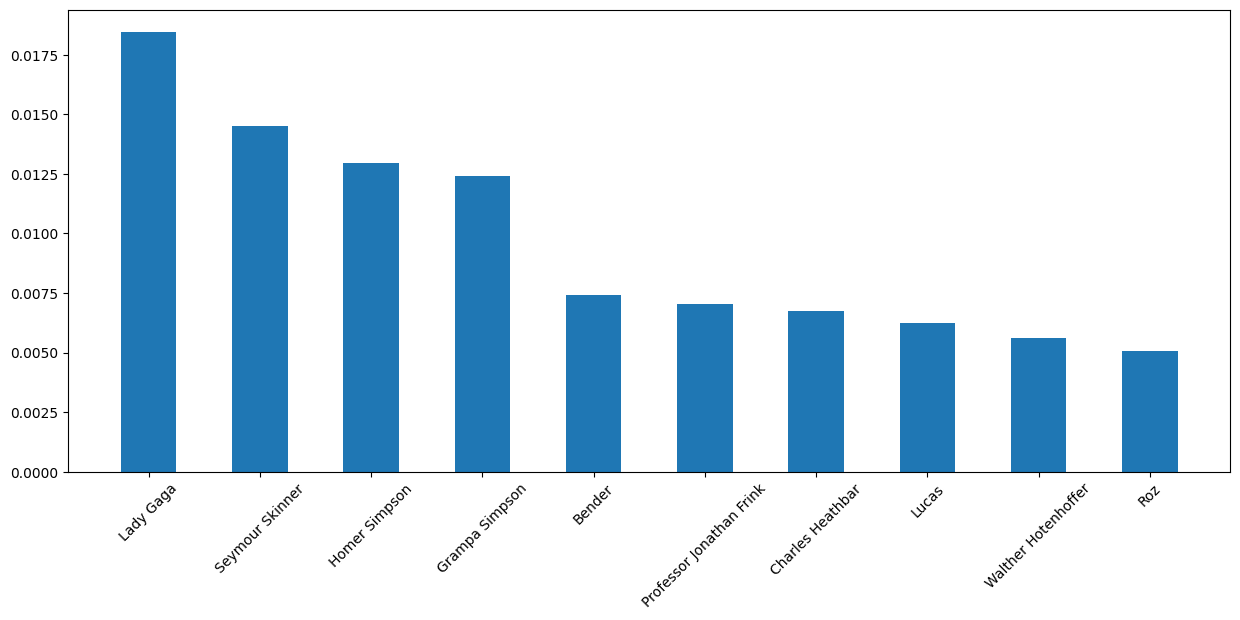

In [19]:
importance_dict_lr = feat_importance_eval(clf_log_best)
plot_feature_importance(importance_dict_lr)

0.8649999999999999

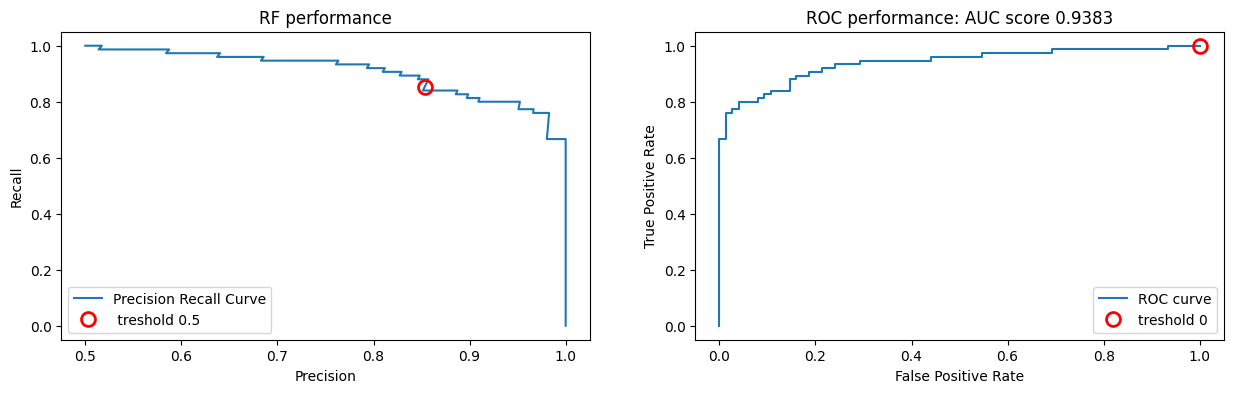

In [20]:
# Try remove the most important feature and see how it affect accuracy
X_all_ablation = X_all_median_imputed.drop(['Lady Gaga'], axis=1)

clf_log_best2 = LogisticRegression(C=clf_cv.best_params_['classifier__C'],
                                                         solver=clf_cv.best_params_['classifier__solver'],
                                                         random_state=1)

mean_score, clf_log_best2 = classifier_assessment(X_all_ablation, y_all, clf_log_best2)
mean_score


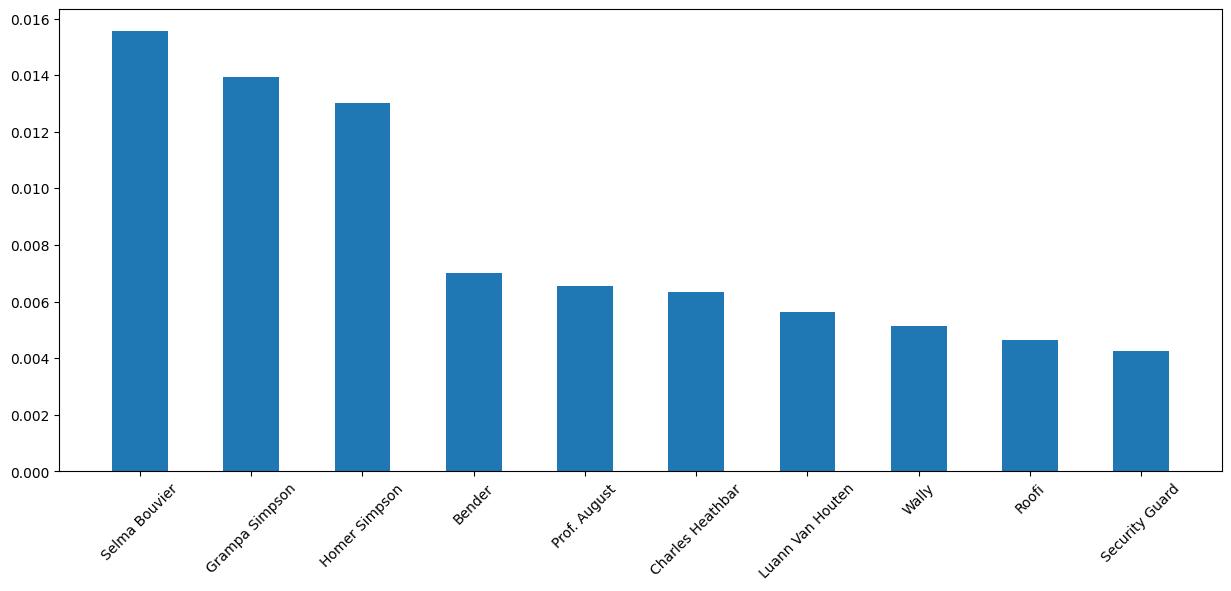

In [21]:
importance_dict_lr2 = feat_importance_eval(clf_log_best2)
plot_feature_importance(importance_dict_lr2)

mean score: 0.865


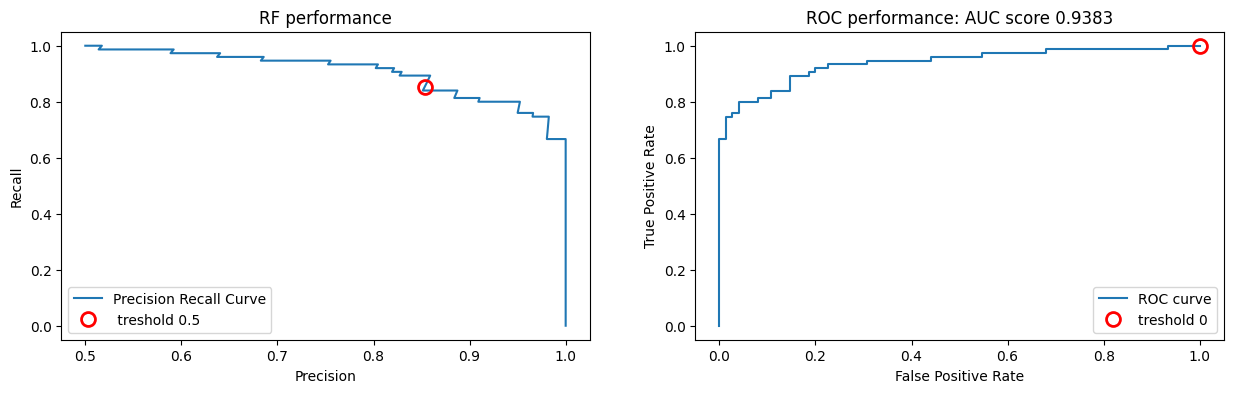

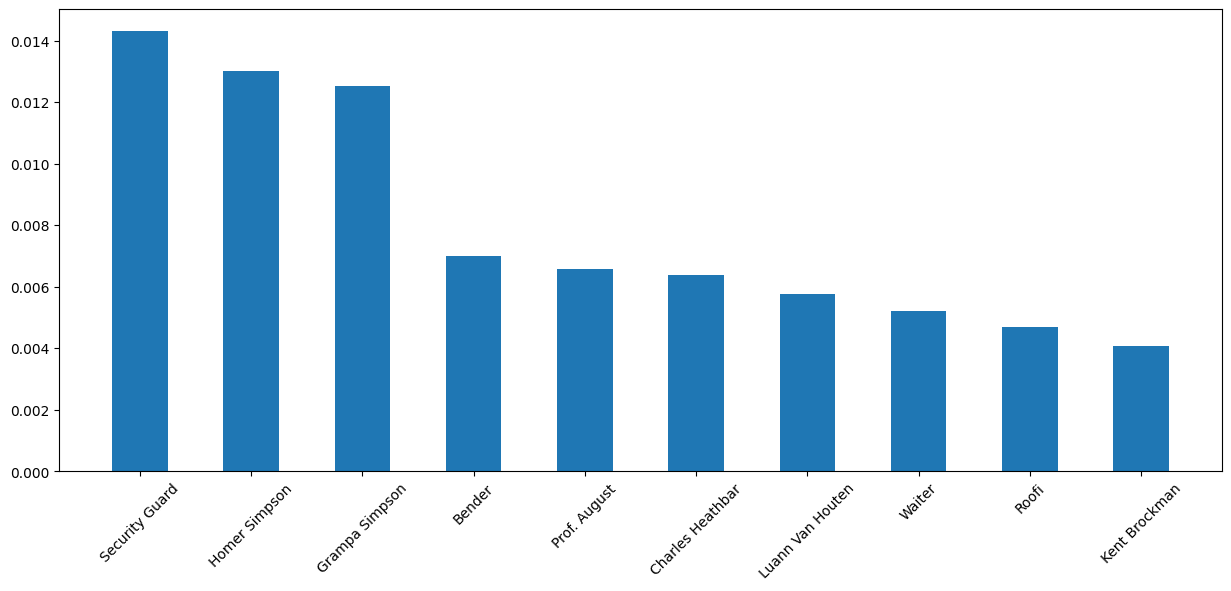

In [22]:
X_all_ablation2 = X_all_ablation.drop('Selma Bouvier', axis=1)
clf_log_best2 = LogisticRegression(C=clf_cv.best_params_['classifier__C'],
                                                         solver=clf_cv.best_params_['classifier__solver'],
                                                         random_state=1)

mean_score, clf_log_best2 = classifier_assessment(X_all_ablation2, y_all, clf_log_best2)
print('mean score:', mean_score)

importance_dict_lr2 = feat_importance_eval(clf_log_best2)
plot_feature_importance(importance_dict_lr2)

mean score: 0.8433333333333334


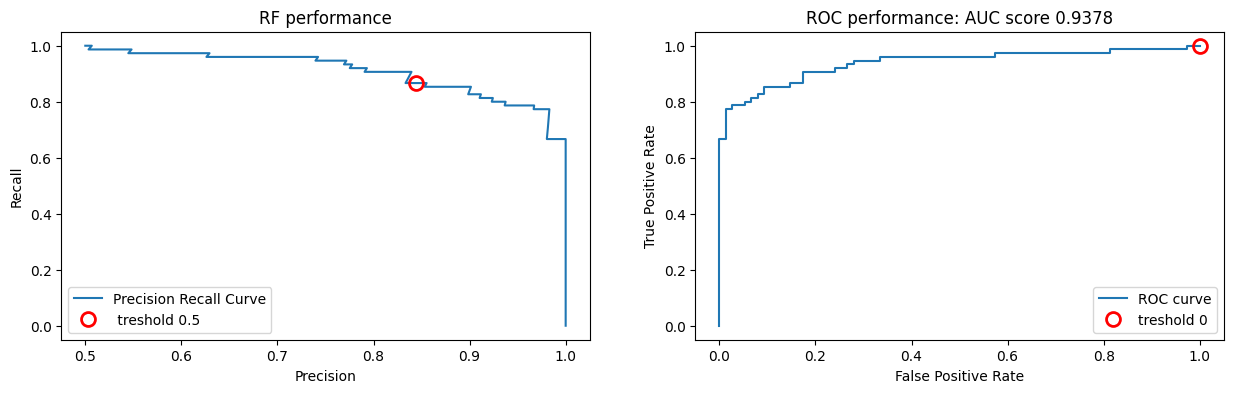

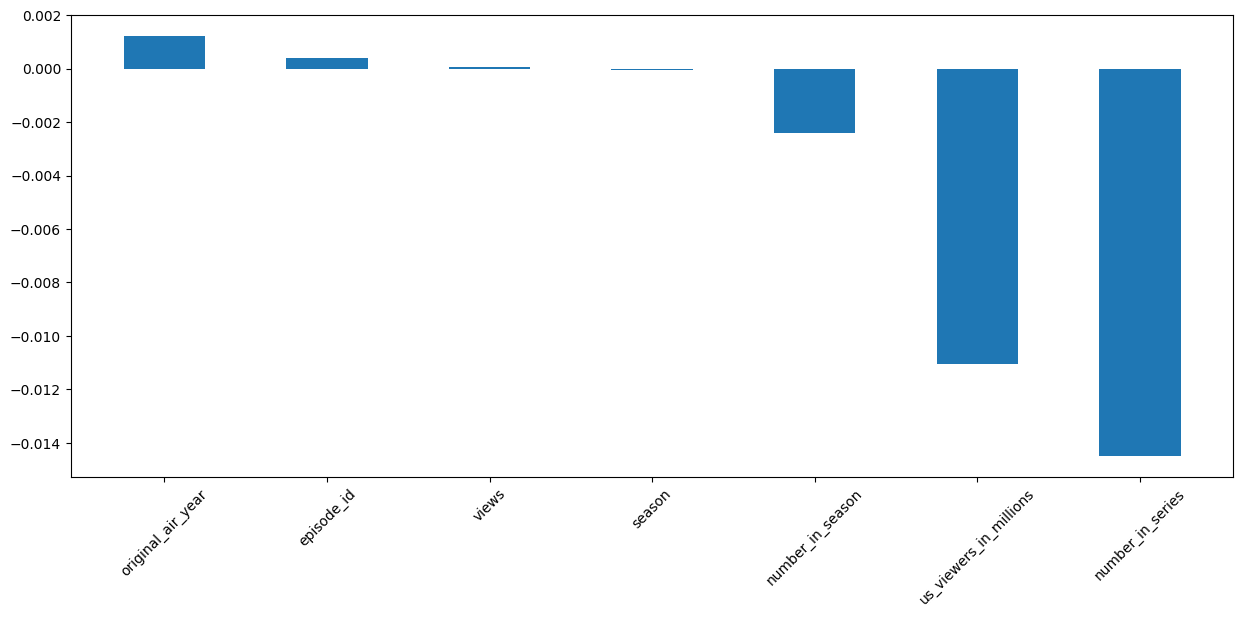

In [23]:
# Try if we only use episode features
episode_columns = ['episode_id','number_in_season', 'number_in_series', 'season', 
                   'original_air_year', 'us_viewers_in_millions', 'views']
X_all_ablation3 = X_all_median_imputed[episode_columns]

clf_log_best3= LogisticRegression(C=clf_cv.best_params_['classifier__C'],
                                     solver=clf_cv.best_params_['classifier__solver'],
                                     random_state=1)
mean_score, clf_log_best3 = classifier_assessment(X_all_ablation3, y_all, clf_log_best3)
print('mean score:', mean_score)

importance_dict_lr3 = feat_importance_eval(clf_log_best3, columns=episode_columns)
plot_feature_importance(importance_dict_lr3)

# 2. Naive Bayes Classifier (accuracy: 0.642 - 0.835)

0.6416666666666667

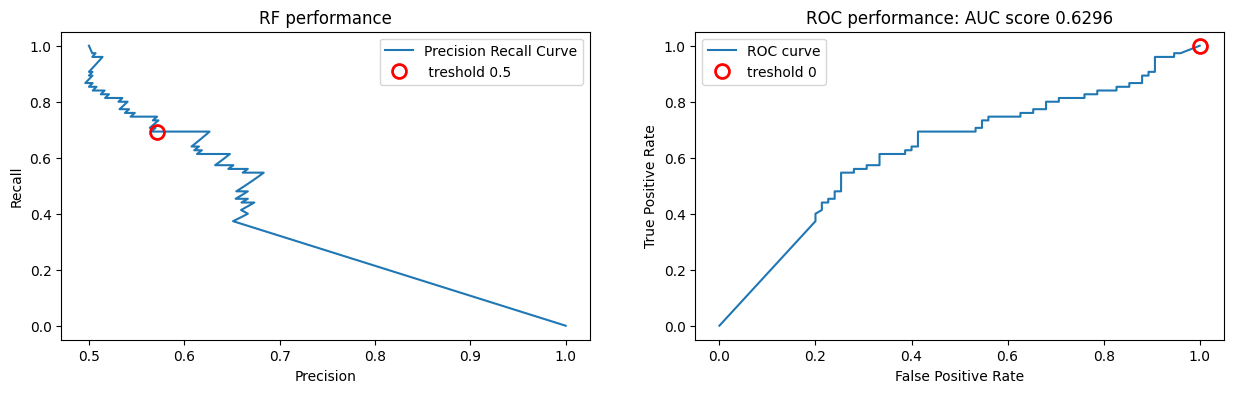

In [24]:
from sklearn.naive_bayes import GaussianNB

clf_nb = GaussianNB(priors=None)
mean_score, clf_nb = classifier_assessment(X_all_mean_imputed, y_all, clf_nb)
mean_score

0.6483333333333333

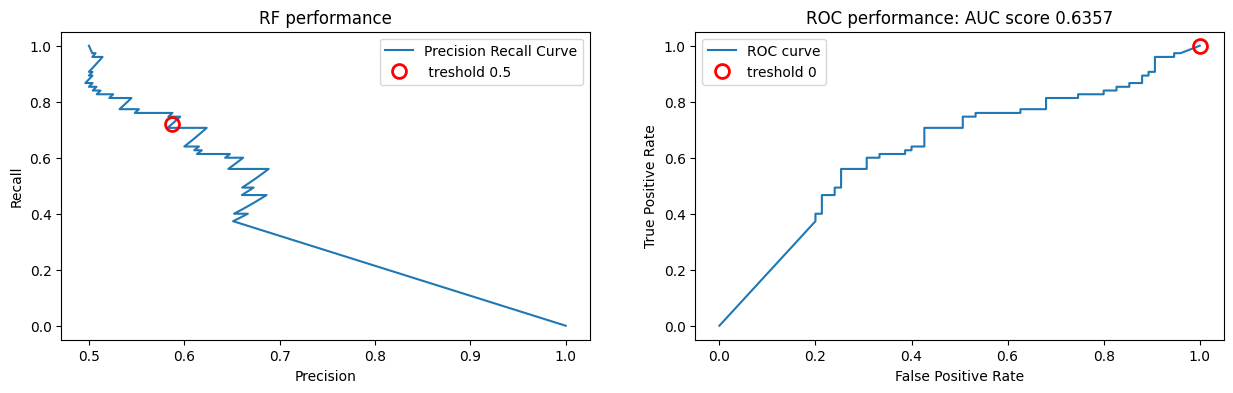

In [25]:
clf_nb = GaussianNB(priors=None)
mean_score, clf_nb = classifier_assessment(X_all_zero_imputed, y_all, clf_nb)
mean_score

0.645

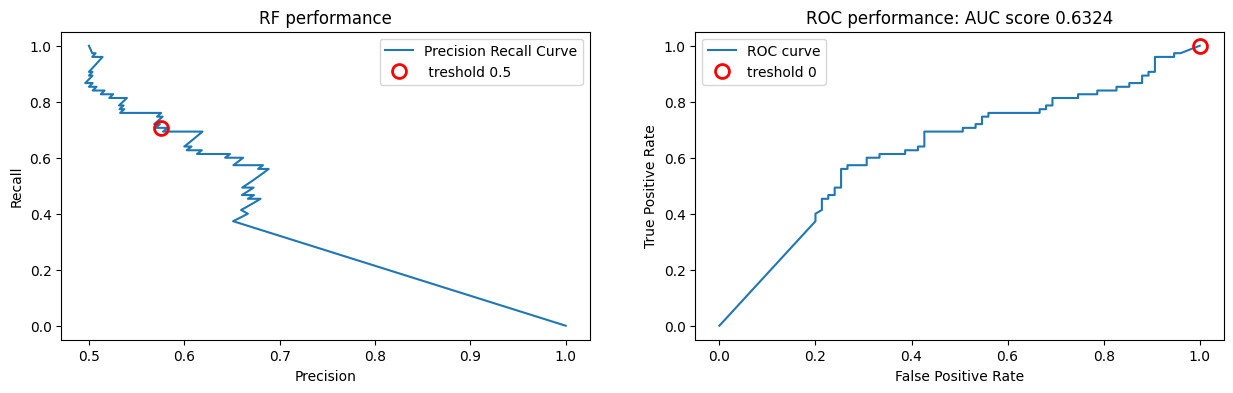

In [26]:
clf_nb = GaussianNB(priors=None)
mean_score, clf_nb = classifier_assessment(X_all_median_imputed, y_all, clf_nb)
mean_score

0.835

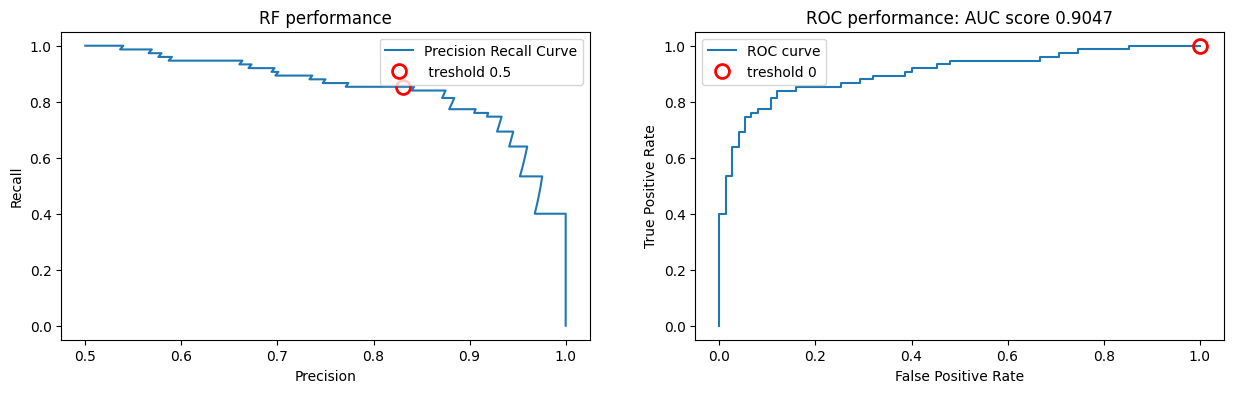

In [27]:
clf_nb_best = GaussianNB(priors=None)
mean_score, clf_nb_best = classifier_assessment(X_all[top_columns].fillna(X_all[top_columns].mean()), y_all, clf_nb_best)
mean_score

0.8283333333333334

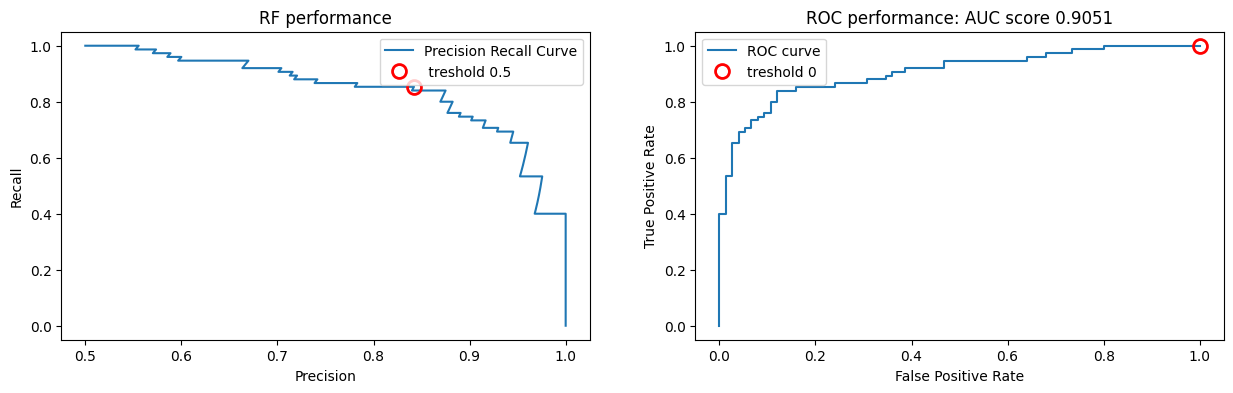

In [28]:
clf_nb = GaussianNB(priors=None)
mean_score, clf_nb = classifier_assessment(X_all[top_columns].fillna(0), y_all, clf_nb)
mean_score

0.8333333333333333

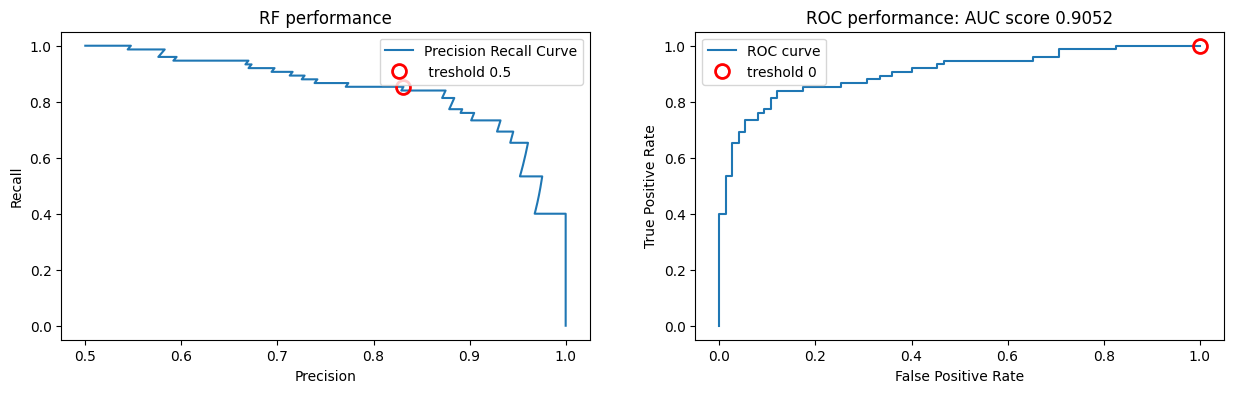

In [29]:
clf_nb = GaussianNB(priors=None)
mean_score, clf_nb = classifier_assessment(X_all[top_columns].fillna(X_all[top_columns].median()), y_all, clf_nb)
mean_score

# 3. Random Forest (accuracy: 0.867 - 0.875)

0.8683333333333334

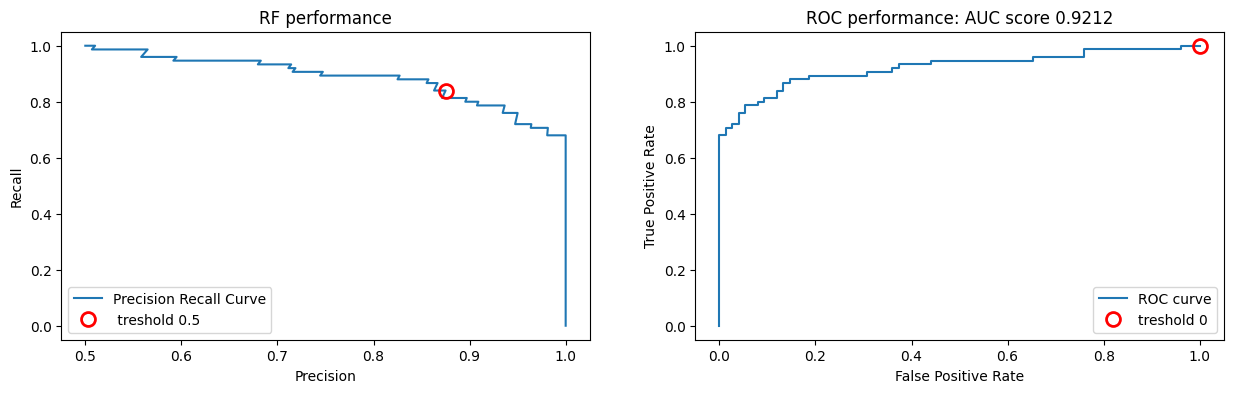

In [30]:
from sklearn.ensemble import RandomForestClassifier

clf_rf_mean = RandomForestClassifier(max_depth=11, random_state=0)
mean_score, clf_rf_mean = classifier_assessment(X_all_mean_imputed, y_all, clf_rf_mean)
mean_score

0.875

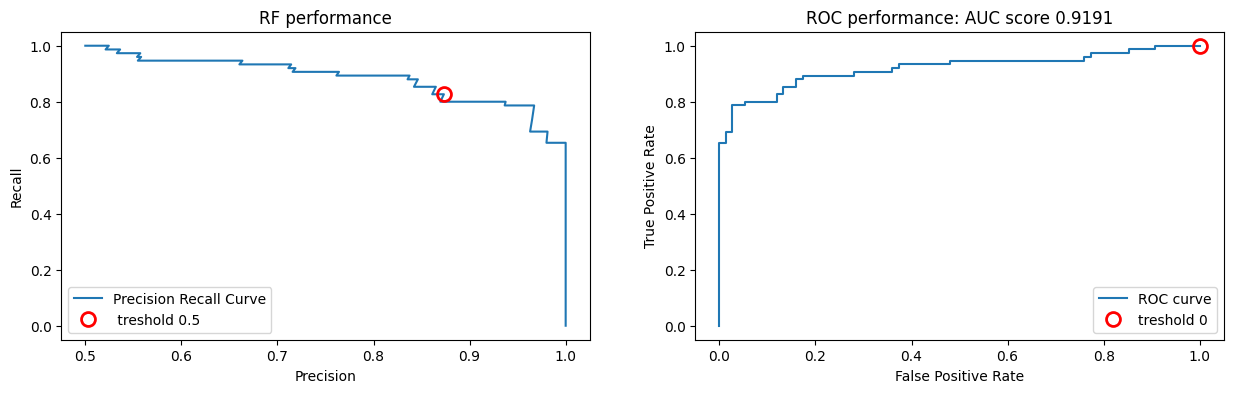

In [59]:
clf_rf_zero = RandomForestClassifier(max_depth=11, random_state=0)
mean_score, clf_rf_zero = classifier_assessment(X_all_zero_imputed, y_all, clf_rf_zero)
mean_score

0.8666666666666666

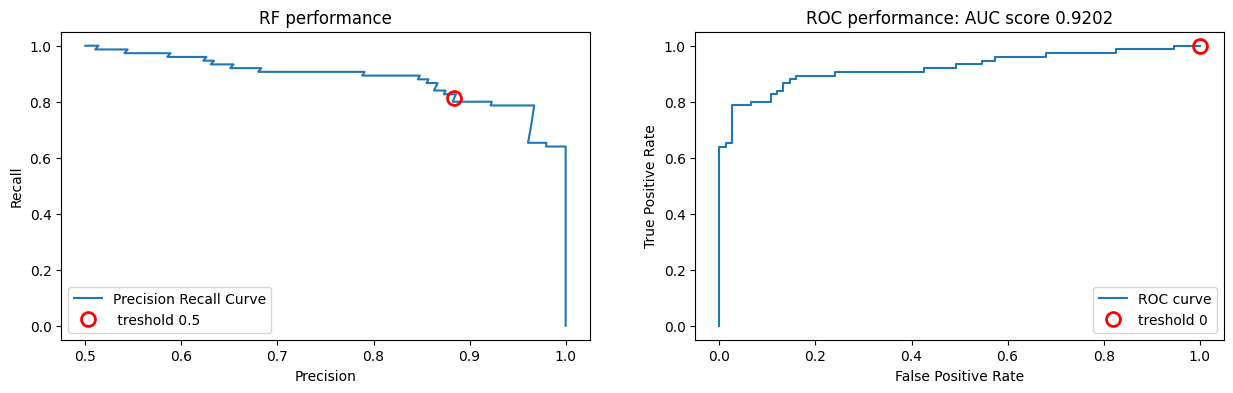

In [32]:
clf_rf_median = RandomForestClassifier(max_depth=11, random_state=0)
mean_score, clf_rf_median = classifier_assessment(X_all_median_imputed, y_all, clf_rf_median)
mean_score

In [69]:
pipe = Pipeline([('classifier', RandomForestClassifier(random_state=1, n_jobs=-1))])
param_grid = [{'classifier':[RandomForestClassifier(random_state=1, n_jobs=-1)],
               'classifier__max_depth':[5,11,20],
               'classifier__n_estimators':[100, 140]}]
clf_rf_cv = GridSearchCV(pipe, param_grid=param_grid, cv=5, verbose=True, n_jobs=-1)
X_train, X_test, y_train, y_test = train_test_split(X_all_zero_imputed, y_all['popularity_class'].ravel(), random_state=1)
clf_rf_cv.fit(X_train, y_train)
clf_rf_cv.best_params_

Fitting 5 folds for each of 6 candidates, totalling 30 fits


{'classifier': RandomForestClassifier(max_depth=20, n_estimators=140, n_jobs=-1,
                        random_state=1),
 'classifier__max_depth': 20,
 'classifier__n_estimators': 140}

0.8733333333333334

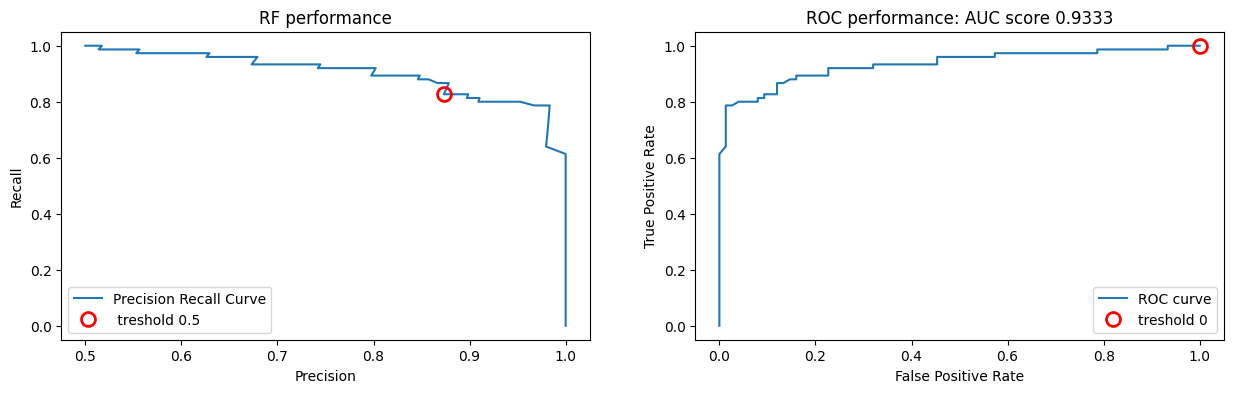

In [70]:
clf_rf_best = RandomForestClassifier(max_depth=clf_rf_cv.best_params_['classifier__max_depth'],
                                     n_estimators=clf_rf_cv.best_params_['classifier__n_estimators'],
                                     random_state=1, n_jobs=-1)
mean_score, clf_rf_best = classifier_assessment(X_all_zero_imputed, y_all, clf_rf_best)
mean_score

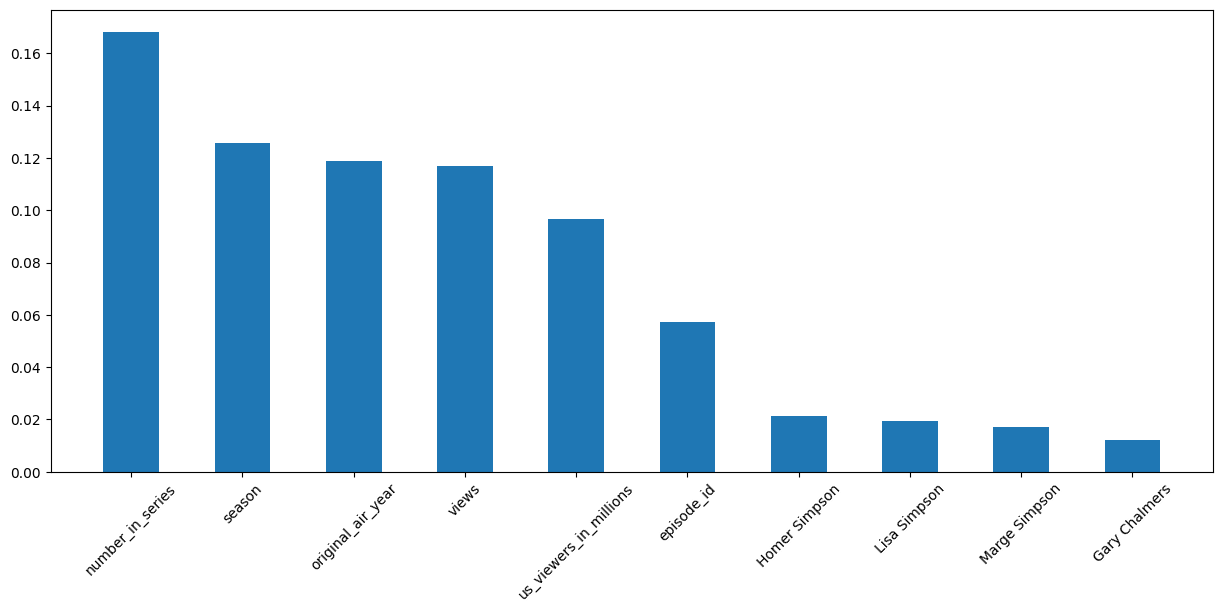

In [62]:
# feature_importance
importance_dict_rf = feat_importance_eval(clf_rf_best)
plot_feature_importance(importance_dict_rf)

# 4. SVM (accuracy score: 0.56 - 0.825)

0.5599999999999999

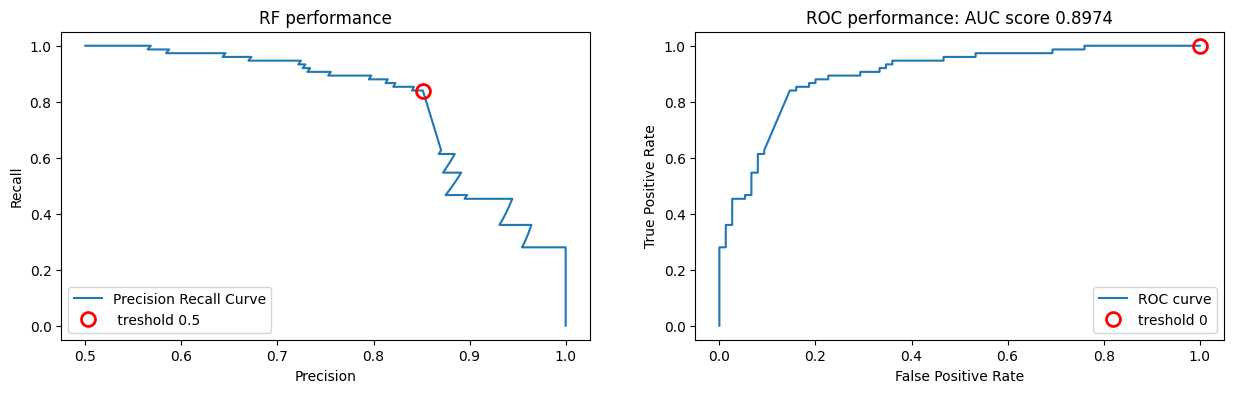

In [73]:
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

clf_svc = make_pipeline(StandardScaler(), SVC(gamma='auto', probability=True))
mean_score, clf_svc = classifier_assessment(X_all_median_imputed, y_all, clf_svc)
mean_score

0.825

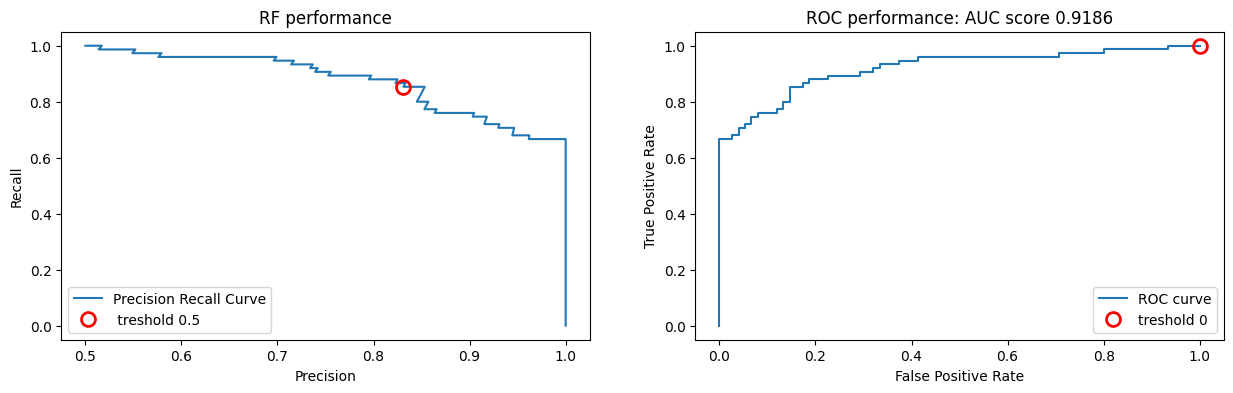

In [77]:
clf_svc = make_pipeline(StandardScaler(), SVC(gamma='auto', probability=True))
mean_score, clf_svc = classifier_assessment(X_all[top_columns].fillna(X_all[top_columns].mean()), y_all, clf_svc)
mean_score

0.8233333333333333

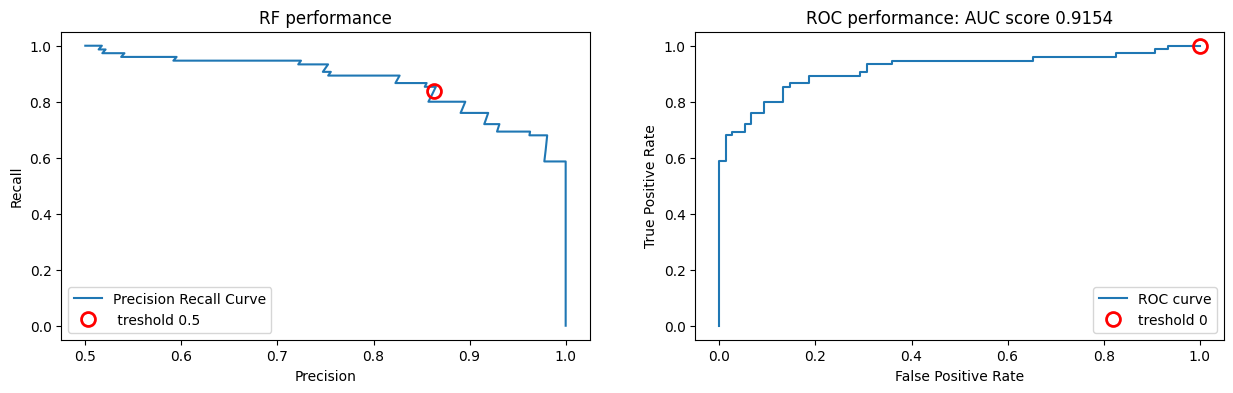

In [75]:
clf_svc = make_pipeline(StandardScaler(), SVC(gamma='auto', probability=True))
mean_score, clf_svc = classifier_assessment(X_all[top_columns].fillna(0), y_all, clf_svc)
mean_score

0.8233333333333333

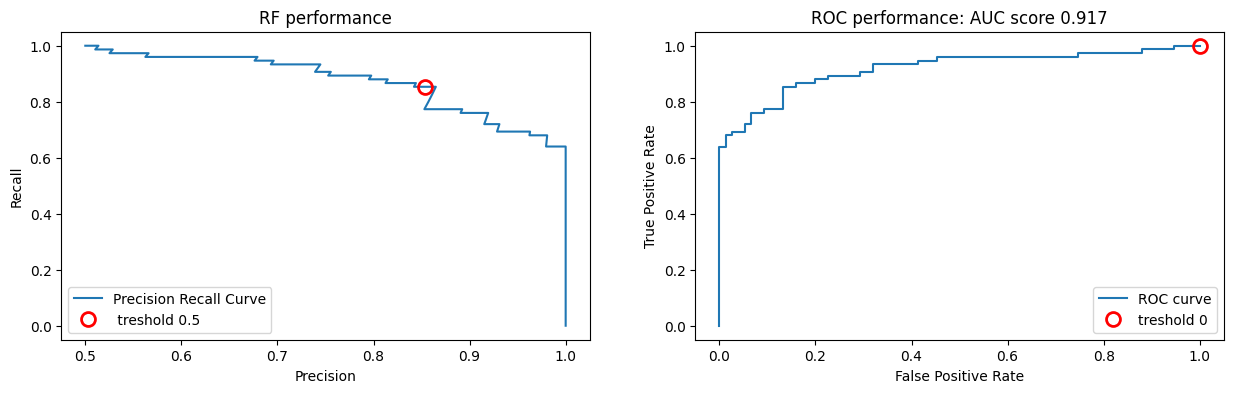

In [76]:
clf_svc = make_pipeline(StandardScaler(), SVC(gamma='auto', probability=True))
mean_score, clf_svc = classifier_assessment(X_all[top_columns].fillna(X_all[top_columns].median()), y_all, clf_svc)
mean_score

In [100]:
clf_svc = make_pipeline(StandardScaler(), SVC(probability=True))

param_grid = [{'svc__C':[0.5, 1, 5],
               'svc__gamma': ['auto', 'scale', 1],
               'svc__kernel':['rbf', 'linear']}]
clf_svc_cv = GridSearchCV(clf_svc, param_grid=param_grid, cv=5, verbose=True, n_jobs=-1)

X_train, X_test, y_train, y_test = train_test_split(X_all[top_columns].fillna(X_all[top_columns].mean()), y_all['popularity_class'].ravel(), random_state=1)
clf_svc_cv.fit(X_train, y_train)
clf_svc_cv.best_params_

Fitting 5 folds for each of 18 candidates, totalling 90 fits


{'svc__C': 1, 'svc__gamma': 'auto', 'svc__kernel': 'rbf'}

0.825

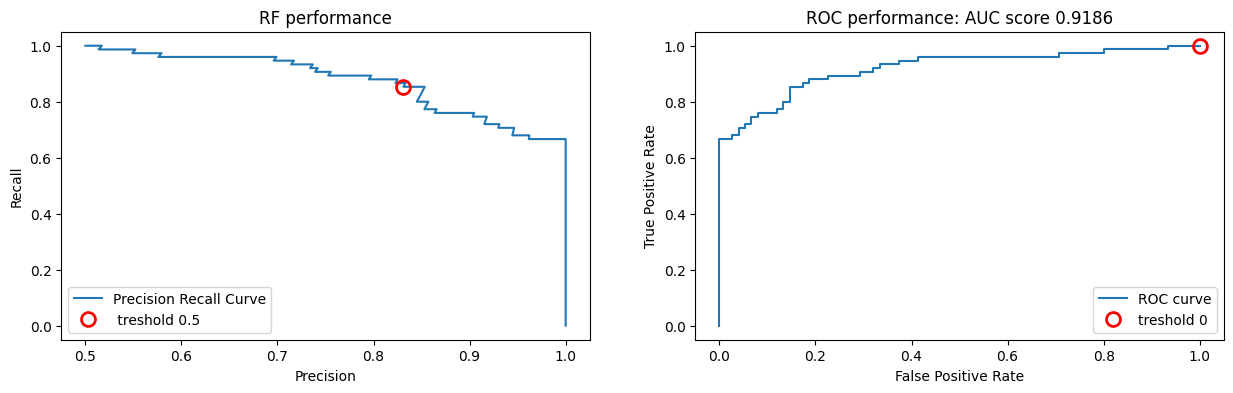

In [101]:
clf_svc_best = make_pipeline(StandardScaler(), SVC(C=clf_svc_cv.best_params_['svc__C'],
                                                   gamma=clf_svc_cv.best_params_['svc__gamma'],
                                                   kernel=clf_svc_cv.best_params_['svc__kernel'],
                                                   probability=True))
mean_score, clf_svc_best = classifier_assessment(X_all[top_columns].fillna(X_all[top_columns].mean()), y_all, clf_svc_best)
mean_score

# 5. XGBoost (accuracy score: 0.86 - 0.88)

0.8800000000000001

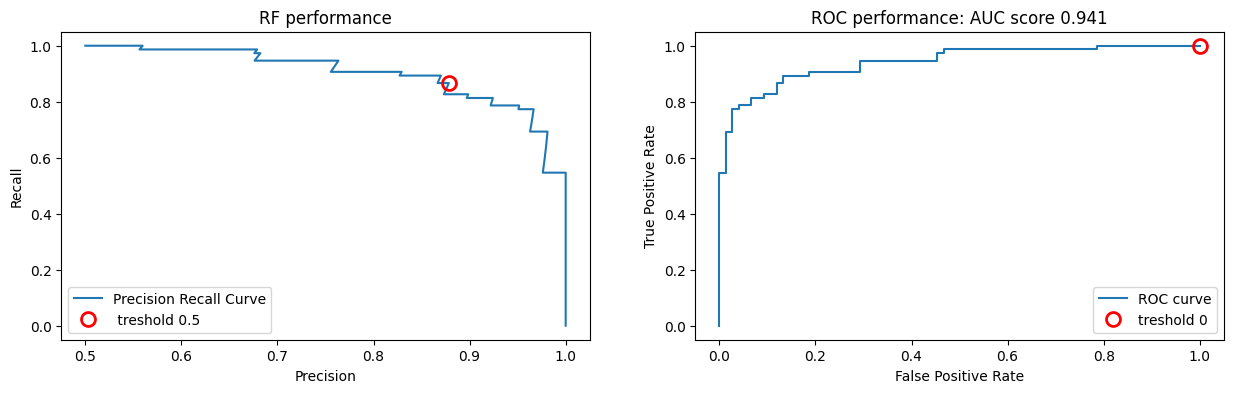

In [102]:
import xgboost as xgb

xgb_clf = xgb.XGBClassifier(eval_metric='mlogloss')
mean_score, xgb_clf = classifier_assessment(X_all_mean_imputed, y_all, xgb_clf)
mean_score

0.8716666666666665

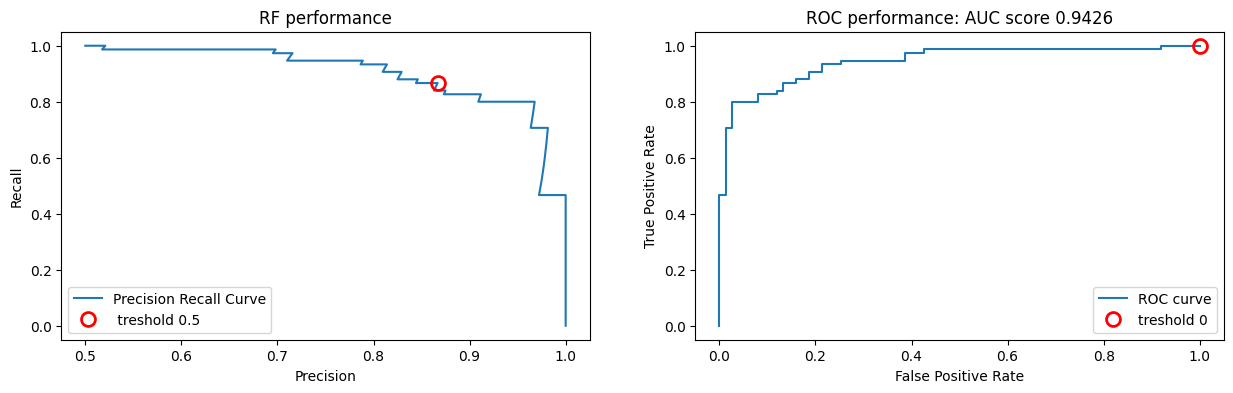

In [103]:
xgb_clf = xgb.XGBClassifier(eval_metric='mlogloss')
mean_score, xgb_clf = classifier_assessment(X_all_zero_imputed, y_all, xgb_clf)
mean_score

0.8616666666666667

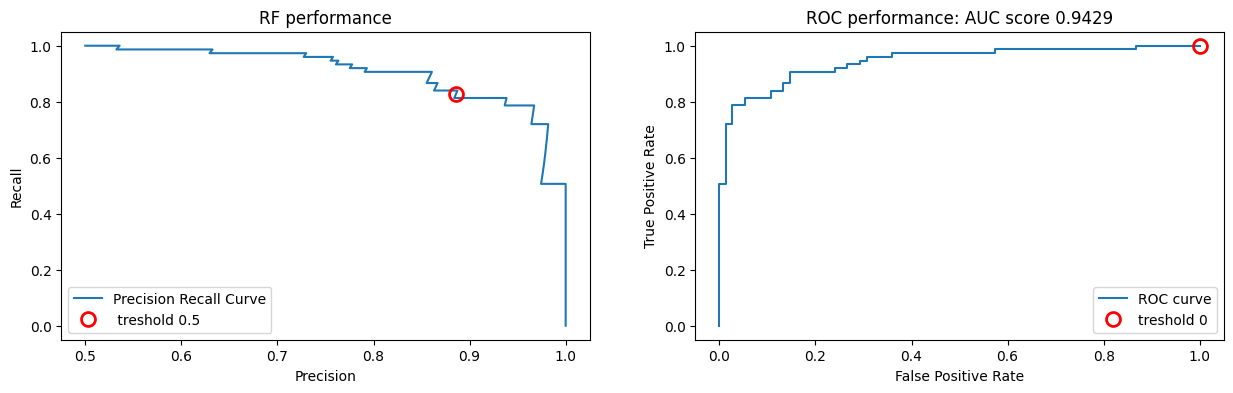

In [104]:
xgb_clf = xgb.XGBClassifier(eval_metric='mlogloss')
mean_score, xgb_clf = classifier_assessment(X_all_median_imputed, y_all, xgb_clf)
mean_score

In [105]:
param_grid = {'max_depth': [1,3,5],
              'learning_rate': [0.01, 0.05, 0.1],
              'gamma': [0, 0.25, 1, 10, 20],
              'reg_lambda': [0, 1, 10, 30, 50],
              'scale_pos_weight': [1, 3, 5],
              'subsample': [0.8],
              'colsample_bytree': [0.5]}

xgb_clf = xgb.XGBClassifier(eval_metric='mlogloss')

grid_cv = GridSearchCV(xgb_clf, param_grid=param_grid, cv=3, n_jobs=-1, scoring='accuracy')
_ = grid_cv.fit(X_all_mean_imputed, y_all)

grid_cv.best_params_

{'colsample_bytree': 0.5,
 'gamma': 0,
 'learning_rate': 0.01,
 'max_depth': 1,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'subsample': 0.8}

In [108]:
xgb_best = xgb.XGBClassifier(colsample_bytree=grid_cv.best_params_['colsample_bytree'],
                             gamma=grid_cv.best_params_['gamma'],
                             learning_rate=grid_cv.best_params_['learning_rate'],
                             max_depth=grid_cv.best_params_['max_depth'],
                             reg_lambda=grid_cv.best_params_['reg_lambda'],
                             scale_pos_weight=grid_cv.best_params_['scale_pos_weight'],
                             subsample=grid_cv.best_params_['subsample'],
                             eval_metric='mlogloss')

0.8800000000000001

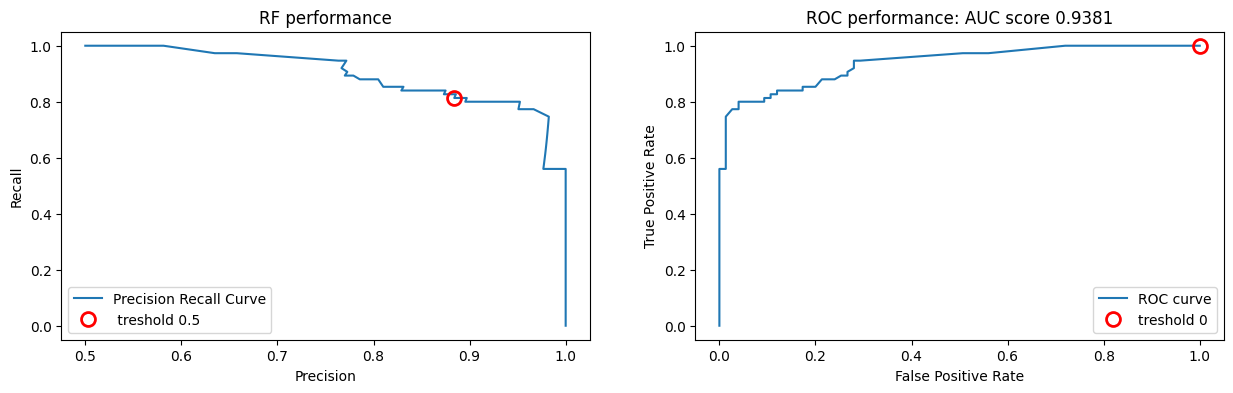

In [109]:
mean_score, clf_xgb = classifier_assessment(X_all_mean_imputed, y_all, xgb_best)
mean_score

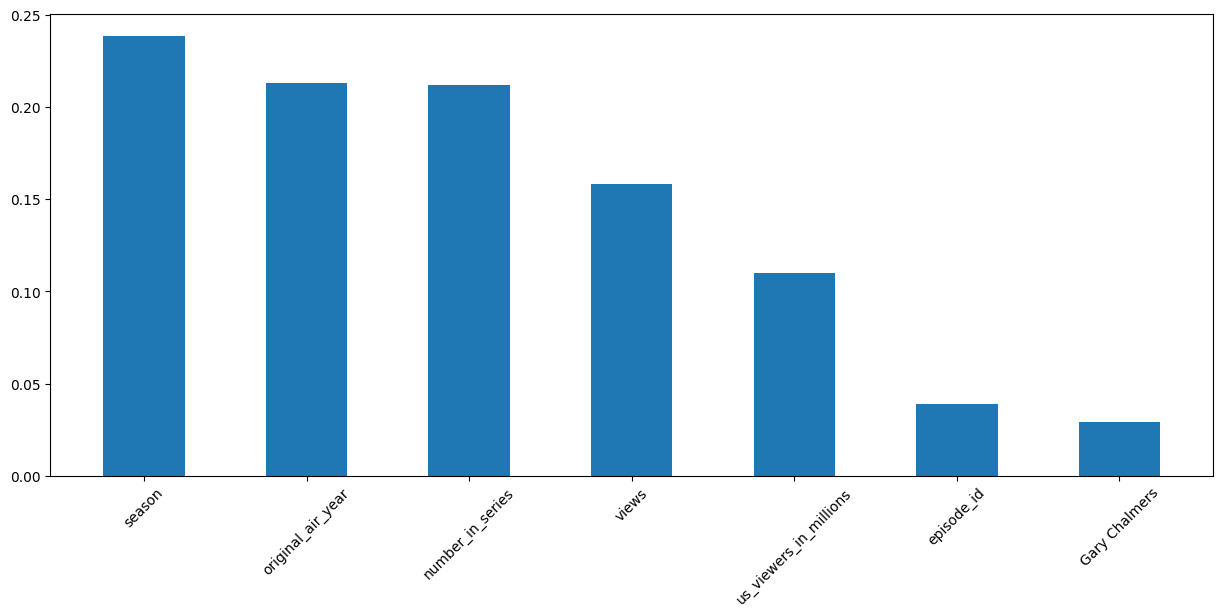

In [110]:
importance_dict_xgb = feat_importance_eval(clf_xgb)
plot_feature_importance(importance_dict_xgb)

0.8800000000000001

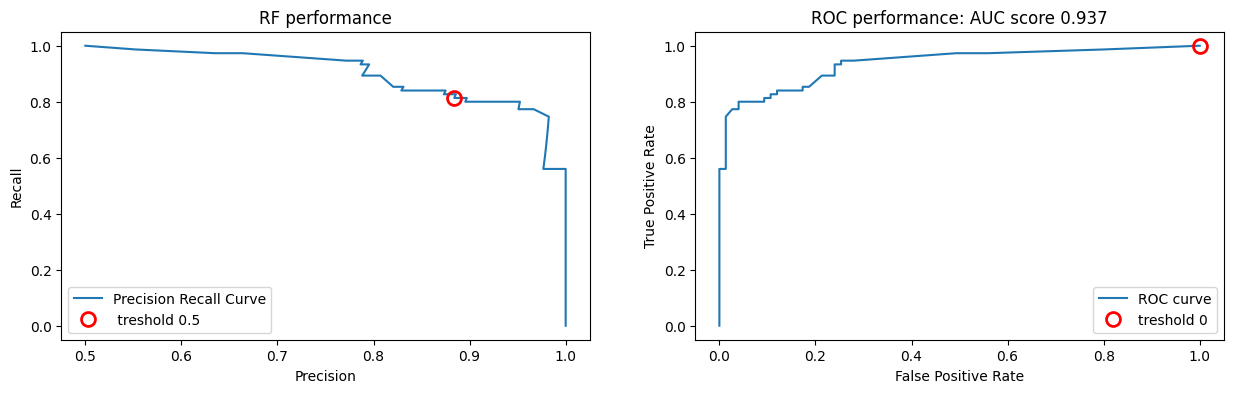

In [111]:
mean_score, clf_xgb2 = classifier_assessment(X_all_zero_imputed, y_all, xgb_best)
mean_score

0.8800000000000001

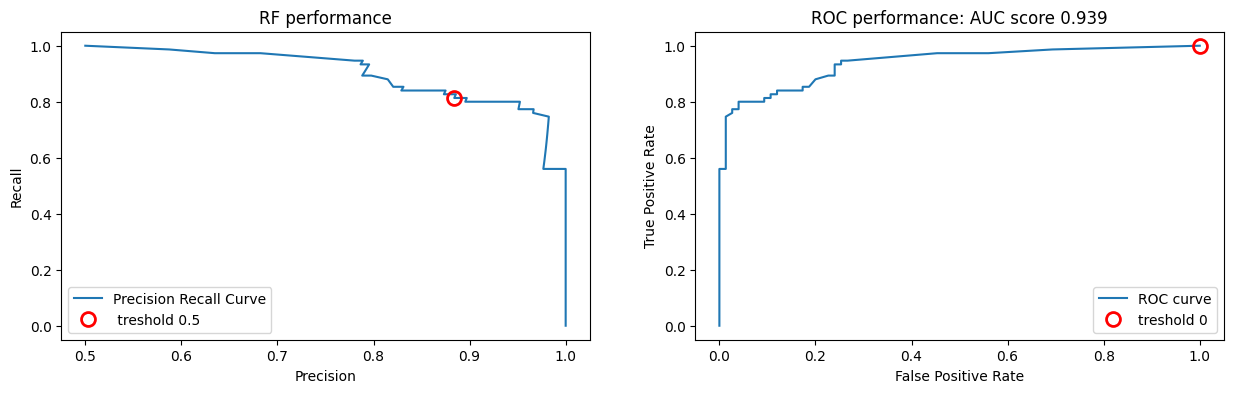

In [112]:
mean_score, clf_xgb3 = classifier_assessment(X_all_median_imputed, y_all, xgb_best)
mean_score

0.8800000000000001

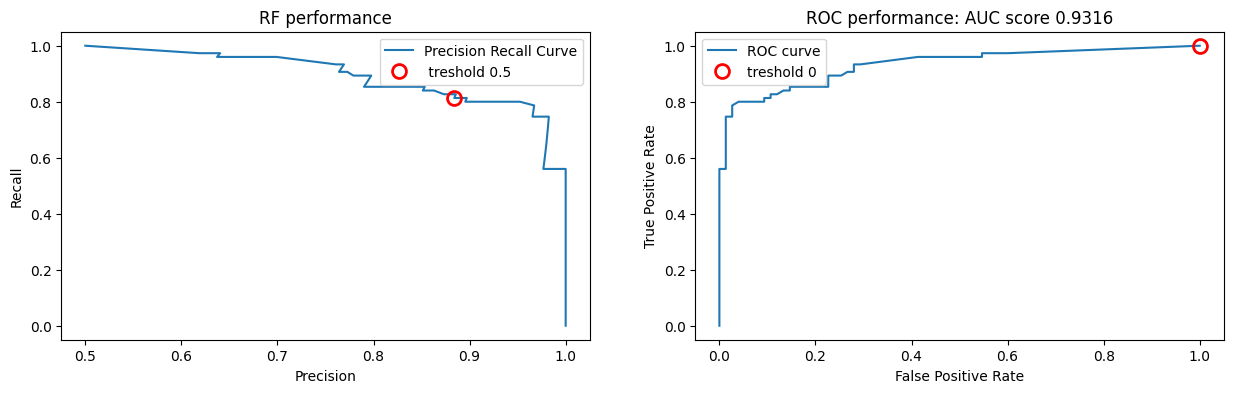

In [113]:
mean_score, clf_xgb4 = classifier_assessment(X_all[top_columns].fillna(X_all[top_columns].mean()), y_all, xgb_best)
mean_score

# Conclusion

Best performing model is XGBoost with average accuracy for the model 0.88.